# Clasificación de Tumores Cerebrales con CNN (Entrenamiento y Validación 80/20)

Este notebook está preparado para el desarrollo y entrenamiento de una CNN sobre imágenes MRI. Incluye:
- Separación automática 80/20 para entrenamiento y validación
- Visualización de datos
- Definición y entrenamiento del modelo
- Guardado automático de checkpoints cada N épocas
- Tamaño de imagen: 512x512 píxeles

In [9]:
# Importar bibliotecas necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Configuración de semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Comprobar si hay GPU disponible
print("Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(f"  {device.name}")
print(f"¿GPU disponible? {'GPU' in [d.device_type for d in tf.config.list_physical_devices()]}")

Dispositivos disponibles:
  /physical_device:CPU:0
¿GPU disponible? False


In [10]:
# Configuración de rutas
BASE_DIR = Path(os.path.join(os.getcwd(), '../total/archive/Training'))
print(f"BASE_DIR: {BASE_DIR}")

# Detectar clases automáticamente
classes = [d.name for d in BASE_DIR.iterdir() if d.is_dir()]
print(f"Clases detectadas: {classes}")
num_classes = len(classes)

# Parámetros
IMG_SIZE = 512  # Tamaño de imagen actualizado a 512x512
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.001
CHECKPOINT_EVERY = 5  # Guardar cada N épocas
MODEL_DIR = Path(os.path.join(os.getcwd(), '../models'))
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BASE_DIR: c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\total\archive\Training
Clases detectadas: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [11]:
# Generador de datos con separación 80/20 (entrenamiento/validación)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% val
)

train_generator = train_datagen.flow_from_directory(
    str(BASE_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),  # Actualizado a 512x512
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    str(BASE_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),  # Actualizado a 512x512
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("Mapeo de clases:", class_indices)

Found 4604 images belonging to 4 classes.
Found 1148 images belonging to 4 classes.
Mapeo de clases: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


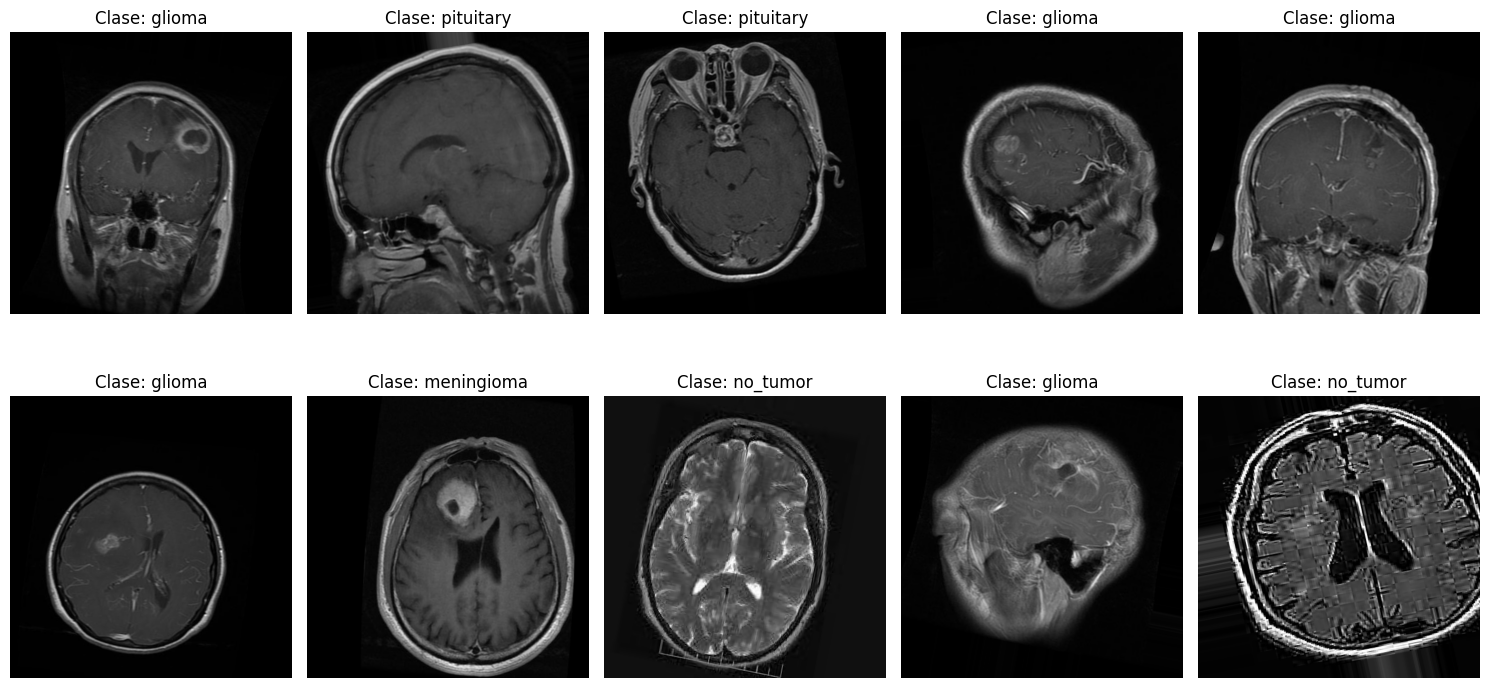

In [12]:
# Visualizar algunas imágenes de entrenamiento
plt.figure(figsize=(15, 8))
images, labels = next(train_generator)
labels = np.argmax(labels, axis=1)
for i in range(min(10, len(images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Clase: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Definir arquitectura de la CNN
def create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,744,004 (514.01 MB)

 Trainable params: 134,741,508 (514.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
# Callbacks: EarlyStopping, ReduceLROnPlateau, y ModelCheckpoint cada N épocas
checkpoint_path = str(MODEL_DIR / 'cnn_checkpoint_epoch_{epoch:02d}.h5')
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq= CHECKPOINT_EVERY,
    monitor='val_loss',
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [16]:
# Entrenamiento del modelo con validación
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5653 - loss: 1.2388
Epoch 1: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_01.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 699s 5s/step - accuracy: 0.5658 - loss: 1.2373 - val_accuracy: 0.2464 - val_loss: 3.4368 - learning_rate: 0.0010
Epoch 2/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - accuracy: 0.5000 - loss: 1.2917

c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_02.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - accuracy: 0.5000 - loss: 1.2917 - val_accuracy: 0.2589 - val_loss: 3.4114 - learning_rate: 0.0010
Epoch 3/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7048 - loss: 0.7758
Epoch 3: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_03.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.7049 - loss: 0.7755 - val_accuracy: 0.2491 - val_loss: 3.5268 - learning_rate: 0.0010
Epoch 4/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7188 - loss: 0.7221
Epoch 4: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_04.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 348ms/step - accuracy: 0.7188 - loss: 0.7221 - val_accuracy: 0.2473 - val_loss: 3.7333 - learning_rate: 0.0010
Epoch 5/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7585 - loss: 0.6313
Epoch 5: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_05.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 597s 4s/step - accuracy: 0.7586 - loss: 0.6311 - val_accuracy: 0.2777 - val_loss: 2.4168 - learning_rate: 0.0010
Epoch 6/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 10:54 5s/step - accuracy: 0.7500 - loss: 0.6510
Epoch 6: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_06.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 343ms/step - accuracy: 0.7500 - loss: 0.6510 - val_accuracy: 0.2786 - val_loss: 2.6551 - learning_rate: 0.0010
Epoch 7/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7823 - loss: 0.5440
Epoch 7: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_07.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 582s 4s/step - accuracy: 0.7823 - loss: 0.5439 - val_accuracy: 0.4205 - val_loss: 1.7794 - learning_rate: 0.0010
Epoch 8/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:33 4s/step - accuracy: 0.8125 - loss: 0.4701
Epoch 8: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_08.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.8125 - loss: 0.4701 - val_accuracy: 0.4464 - val_loss: 1.6787 - learning_rate: 0.0010
Epoch 9/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8127 - loss: 0.4767
Epoch 9: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_09.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.8127 - loss: 0.4768 - val_accuracy: 0.3063 - val_loss: 2.5965 - learning_rate: 0.0010
Epoch 10/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.9062 - loss: 0.2308
Epoch 10: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_10.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.9062 - loss: 0.2308 - val_accuracy: 0.3089 - val_loss: 2.5269 - learning_rate: 0.0010
Epoch 11/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7979 - loss: 0.5196
Epoch 11: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_11.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.7979 - loss: 0.5194 - val_accuracy: 0.5071 - val_loss: 1.6522 - learning_rate: 0.0010
Epoch 12/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:10 4s/step - accuracy: 0.8125 - loss: 0.3254
Epoch 12: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_12.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 340ms/step - accuracy: 0.8125 - loss: 0.3254 - val_accuracy: 0.4634 - val_loss: 1.7989 - learning_rate: 0.0010
Epoch 13/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8393 - loss: 0.4345
Epoch 13: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_13.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 584s 4s/step - accuracy: 0.8392 - loss: 0.4345 - val_accuracy: 0.4634 - val_loss: 2.1520 - learning_rate: 0.0010
Epoch 14/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.8438 - loss: 0.4172
Epoch 14: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_14.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 328ms/step - accuracy: 0.8438 - loss: 0.4172 - val_accuracy: 0.4839 - val_loss: 2.1429 - learning_rate: 0.0010
Epoch 15/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7926 - loss: 0.4926
Epoch 15: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_15.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.7928 - loss: 0.4924 - val_accuracy: 0.3598 - val_loss: 9.1092 - learning_rate: 0.0010
Epoch 16/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.8750 - loss: 0.3858
Epoch 16: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_16.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 341ms/step - accuracy: 0.8750 - loss: 0.3858 - val_accuracy: 0.3589 - val_loss: 8.9076 - learning_rate: 0.0010
Epoch 17/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8468 - loss: 0.3996
Epoch 17: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_17.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.8468 - loss: 0.3995 - val_accuracy: 0.7652 - val_loss: 0.6442 - learning_rate: 2.0000e-04
Epoch 18/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - accuracy: 0.8438 - loss: 0.3004
Epoch 18: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_18.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 339ms/step - accuracy: 0.8438 - loss: 0.3004 - val_accuracy: 0.7661 - val_loss: 0.6380 - learning_rate: 2.0000e-04
Epoch 19/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8597 - loss: 0.3667
Epoch 19: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_19.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 604s 4s/step - accuracy: 0.8597 - loss: 0.3666 - val_accuracy: 0.7929 - val_loss: 0.6180 - learning_rate: 2.0000e-04
Epoch 20/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.9688 - loss: 0.1783
Epoch 20: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_20.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 333ms/step - accuracy: 0.9688 - loss: 0.1783 - val_accuracy: 0.7955 - val_loss: 0.6264 - learning_rate: 2.0000e-04
Epoch 21/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8761 - loss: 0.3387
Epoch 21: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_21.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 608s 4s/step - accuracy: 0.8761 - loss: 0.3387 - val_accuracy: 0.8134 - val_loss: 0.6046 - learning_rate: 2.0000e-04
Epoch 22/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.8438 - loss: 0.4813
Epoch 22: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_22.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 340ms/step - accuracy: 0.8438 - loss: 0.4813 - val_accuracy: 0.8134 - val_loss: 0.6063 - learning_rate: 2.0000e-04
Epoch 23/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8648 - loss: 0.3377
Epoch 23: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_23.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.8649 - loss: 0.3377 - val_accuracy: 0.4313 - val_loss: 1.9404 - learning_rate: 2.0000e-04
Epoch 24/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.6250 - loss: 0.7105
Epoch 24: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_24.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 339ms/step - accuracy: 0.6250 - loss: 0.7105 - val_accuracy: 0.4491 - val_loss: 1.8639 - learning_rate: 2.0000e-04
Epoch 25/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8743 - loss: 0.3396
Epoch 25: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_25.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.8743 - loss: 0.3395 - val_accuracy: 0.7786 - val_loss: 0.6228 - learning_rate: 2.0000e-04
Epoch 26/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:29 4s/step - accuracy: 0.9062 - loss: 0.2728
Epoch 26: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_26.h5



Epoch 26: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 337ms/step - accuracy: 0.9062 - loss: 0.2728 - val_accuracy: 0.7786 - val_loss: 0.6233 - learning_rate: 2.0000e-04
Epoch 27/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8724 - loss: 0.3278
Epoch 27: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_27.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 599s 4s/step - accuracy: 0.8724 - loss: 0.3278 - val_accuracy: 0.5384 - val_loss: 2.6127 - learning_rate: 4.0000e-05
Epoch 28/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.8438 - loss: 0.4932
Epoch 28: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_28.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - accuracy: 0.8438 - loss: 0.4932 - val_accuracy: 0.5393 - val_loss: 2.6695 - learning_rate: 4.0000e-05
Epoch 29/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8735 - loss: 0.3170
Epoch 29: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_29.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 604s 4s/step - accuracy: 0.8735 - loss: 0.3169 - val_accuracy: 0.6598 - val_loss: 1.2541 - learning_rate: 4.0000e-05
Epoch 30/200
  1/143 ━━━━━━━━━━━━━━━━━━━━ 9:05 4s/step - accuracy: 0.7812 - loss: 0.3874
Epoch 30: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_30.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 339ms/step - accuracy: 0.7812 - loss: 0.3874 - val_accuracy: 0.6723 - val_loss: 1.2724 - learning_rate: 4.0000e-05
Epoch 31/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8791 - loss: 0.3158
Epoch 31: saving model to c:\Users\dev-max\Documents\GitHub\inteligencia_de_negocios\cnn\..\models\cnn_checkpoint_epoch_31.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
143/143 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.8791 - loss: 0.3158 - val_accuracy: 0.7571 - val_loss: 0.8464 - learning_rate: 4.0000e-05
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.


In [ ]:
# Guardar el modelo final
final_model_path = MODEL_DIR / 'brain_tumor_cnn_model_final.h5'
model.save(str(final_model_path))
print(f"Modelo final guardado en: {final_model_path}")

In [ ]:
# Visualización de la curva de pérdida y precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()
plt.show()

**Notas:**
- El entrenamiento se realiza con separación 80/20 para entrenamiento y validación.
- Se guardan checkpoints automáticos cada N épocas y el modelo final al terminar.
- Puedes ajustar los hiperparámetros y arquitectura según tus necesidades.